# <p style="text-align: center;"> All data processing, analyses, and figures from the Ultimate Manuscript. </p>



## Data importing and cleaning
(To see associated experimental stimuli script, [go here](https://bitbucket.org/smweis/frizrf/overview)
We import the necessary modules, and one custom function that wraps up data importing.

In [1]:
#Load and clean data.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import statsmodels.api as sm

# the data importing and processing steps have been carried out to generate mainData.csv (available on Github)

#Get Data
navData = pd.read_csv('https://raw.githubusercontent.com/smweis/Ultimate/master/data/nav_data.csv')
frizData = pd.read_csv('https://raw.githubusercontent.com/smweis/Ultimate/master/data/friz_data.csv')
additionalData = pd.read_csv('https://raw.githubusercontent.com/smweis/Ultimate/master/data/additional_data.csv')
#Recode "psychopycode to participant"
additionalData['participant'] = additionalData['psychopycode']

#Clean data functions
def removeHighRTs(howManySDs,dv,data): 
    ### dv should be a reaction time variable within data. Returns a dataset for use with chooseYourData()
    if howManySDs == 0:
        return data
    rtThresh = howManySDs*np.std(data[dv]) #calculate Std. deviation
    rtMean = np.mean(data[dv]) #calculate mean
    dataThresh = data.loc[data[dv] < (rtMean + rtThresh)] #select only data that is less than the mean + the num of SDs specified
    dataThresh = dataThresh.loc[dataThresh[dv] > 0] # remove any weird answers above 0
    return dataThresh


def removeWrongAnswers(dv,data):
    dataCorrect = data.loc[data[dv] == 1]
    return dataCorrect


def renameFactorLevels(data,friz_or_nav):
    data['condition'] = friz_or_nav
    prompts = sorted(data.prompt1.unique())
    stims = sorted(data.stim1.unique())
    new_stims = ['far_left','far_right','near_left','near_right']

    if friz_or_nav == 'friz':    
        new_prompts = ['Away','Left','Right','Home']
    else:
        new_prompts = ['Away','Home','Left','Right']
        
    for i in range(len(prompts)):
        data = data.replace(prompts[i],new_prompts[i])
        data = data.replace(stims[i],new_stims[i])
        
    return data


def newFactorPrompts(row):
    if row['prompt1'] == 'Home' or row['prompt1'] == 'Away':
        return 'Absolute'
    else:
        return 'Relative'

    
def newFactorStims(row):
    if row['stim1'] == 'near_right' or row['stim1'] == 'near_left':
        return 'Near'
    else:
        return 'Far'

def newFactorAnswers(row):
    if row['stim1'] == 'near_right' or row['stim1'] == 'far_right':
        return 'Right'
    else:
        return 'Left'

def chooseYourData(dfp,reverse=True,stdRtThreshold=2,justCorrect=True):
    ###default are the way the data are analyzed in the paper
    # dfp: dataForPlot - use df
    # reverse: should 'flippers' have their scores reversed for Far-Absolute navigation trials?
    # stdRtThreshold: number of standard deviations to trim above the mean for RT
    # justCorrect: exclude wrong answers
    if reverse: 
        dv_corr = 'newCorrect'
    else:
        dv_corr = 'Trials_responsecorr'
    if stdRtThreshold:
        dfp = removeHighRTs(stdRtThreshold,'Trials_responsert',dfp)
    if justCorrect:
        dfp = removeWrongAnswers(dv_corr, dfp)
        
    return dfp


def ttestAndMeansSDs(dv1,dv2,name1='dv1',name2='dv2'):
    #two-sample between subjects t-test that returns M's, SD's and t-stats
    M1 = dv1.mean()
    M2 = dv2.mean()
    SD1 = dv1.std()
    SD2 = dv2.std()
    t,p = scipy.stats.ttest_ind(dv1,dv2)

    t = abs(t)
    df = dv1.count() + dv2.count() - 2
    d = cohensD_between(M1,M2,SD1,SD2)
    
    if p < .001:
        tText = 't({}) = {:.2f}, p = {:.4f}, d = {:.2f}'.format(df,t,p,d)
    elif p < .01:
        tText = 't({}) = {:.2f}, p = {:.3f}, d = {:.2f}'.format(df,t,p,d)
    else:
        tText = 't({}) = {:.2f}, p = {:.2f}, d = {:.2f}'.format(df,t,p,d)

    dv1Text = '{} M = {:.2f}, SD = {:.2f}; '.format(name1,M1,SD1)
    dv2Text = '{} M = {:.2f}, SD = {:.2f}\n'.format(name2,M2,SD2)

    print(dv1Text,dv2Text, tText)
    
def ttestAndMeansSDswithin(dv1,dv2,name1='dv1',name2='dv2'):
    #two-sample between subjects t-test that returns M's, SD's and t-stats
    M1 = dv1.mean()
    M2 = dv2.mean()
    SD1 = dv1.std()
    SD2 = dv2.std()
    t,p = scipy.stats.ttest_rel(dv1,dv2)

    
    corrs = np.corrcoef(pivoted['Frisbee_Rel_minus_Abs'],pivoted['Nav_Rel_minus_Abs'])
    r = corrs[0,1]
    
    t = abs(t)
    df = dv1.count() - 1
    
    d = cohensD_within(M1,M2,SD1,SD2,r)
    
    if p < .001:
        tText = 't({}) = {:.2f}, p = {:.4f}, d = {:.2f}'.format(df,t,p,d)
    elif p < .01:
        tText = 't({}) = {:.2f}, p = {:.3f}, d = {:.2f}'.format(df,t,p,d)
    else:
        tText = 't({}) = {:.2f}, p = {:.2f}, d = {:.2f}'.format(df,t,p,d)

    dv1Text = '{} M = {:.2f}, SD = {:.2f}; '.format(name1,M1,SD1)
    dv2Text = '{} M = {:.2f}, SD = {:.2f}\n'.format(name2,M2,SD2)

    print(dv1Text,dv2Text,tText)
    
def cohensD_between(M1,M2,SD1,SD2):
    sdPooled = np.sqrt((SD1**2 + SD2**2)/2)
    d = (M1 - M2) / sdPooled
    d = abs(d)
    return d

def cohensD_within(M1,M2,SD1,SD2,r):
    sd1Adj = SD1*(np.sqrt(2*(1-r)))
    sd2Adj = SD2*(np.sqrt(2*(1-r)))
    sdPooled = (sd1Adj+sd2Adj)/2
    d = (M1-M2)/sdPooled
    d = abs(d)
    return d
 
def doubleDistPlot(first,second,data,abs_and_rel=True,title=None,zeroLine=False):
    """Will print two overlaid distplots and print the result of the within-sample t-test between them.
    
    #Use with 'pivoted' like so:
    doubleDistPlot(('Frisbee','Far','Absolute'),('Navigation','Far','Absolute'),pivoted,abs_and_rel=False)
    #Use with 'allpivots' like so:
    doubleDistPlot('FrisbeeHome','FrisbeeAway',allpivots,abs_and_rel=False)
    """
    
    
    if not isinstance(title, str):
        title = '{} and {}'.format(first,second)
        
    
    ax1 = sns.distplot(data[second],label=second)
    sns.distplot(data[first],label=first)
    ax1.set(title=title,xlabel='Seconds',ylabel='Normalized Frequency')
    y1,y2 = ax1.get_ylim()
    x1,x2 = ax1.get_xlim()
    xLeft = x1-(x2-x1)/10
    xRight = x2+(x2-x1)/10
    yMid = (y1+y2)/2
    xMid = (x1+x2)/2
    plt.legend()
    
    if zeroLine:
        plt.axvline(0, color='black')
    
    plt.show()
    
########################################################################################################################
#Rename conditions
frizData = renameFactorLevels(frizData,'Frisbee')
navData = renameFactorLevels(navData,'Navigation')
#Recode stimulus location to a binary variable.
frizData['stimLoc'] = frizData.apply(lambda row: newFactorStims(row),axis=1)
navData['stimLoc'] = navData.apply(lambda row: newFactorStims(row),axis=1)
#Recode prompt type to a binary variable. 
frizData['promptType'] = frizData.apply(lambda row: newFactorPrompts(row),axis=1)
navData['promptType'] = navData.apply(lambda row: newFactorPrompts(row),axis=1)
#Recode left_right type to a binary variable. 
frizData['leftRight'] = frizData.apply(lambda row: newFactorAnswers(row),axis=1)
navData['leftRight'] = navData.apply(lambda row: newFactorAnswers(row),axis=1)


df = frizData.append(navData)

neccessaryAdditionalData = additionalData.loc[:,
                                              ["Sex","Age","participant",
                                               "SBSOD_AVERAGE",
                                               "Friz_Total_Years_Played",
                                               "Friz_Force_Preference",
                                               "Friz_Position"]]



########################################################################################################################
# Deal with flippers
pivotedCorrectAns = df.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsecorr',aggfunc=np.sum)
pivotedRT = df.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsert',aggfunc=np.mean)

corr_thresh = pivotedCorrectAns[('Navigation','Far','Absolute')]< 8
flippersCorr = pivotedCorrectAns[corr_thresh]
nonflippersCorr = pivotedCorrectAns[~corr_thresh]
flippersRT = pivotedRT[corr_thresh]
nonflippersRT = pivotedRT[~corr_thresh]                                 

if 'participant' in neccessaryAdditionalData.columns:
    neccessaryAdditionalData.set_index('participant',inplace=True)

neccessaryAdditionalData.index = neccessaryAdditionalData.index.map(int)
neccessaryAdditionalData.sort_index(inplace=True)
corr_thresh.sort_index(inplace=True)

flippersOtherData = neccessaryAdditionalData[corr_thresh]
nonflippersOtherData = neccessaryAdditionalData[~corr_thresh]




flipper_list = flippersCorr.index.values.tolist()
df['flipper'] = np.where(df.participant.isin(flipper_list),'flipper','nonflipper')

def f(df):
    # Global variables here
    if df['flipper'] == 'flipper' and df['condition'] == 'Navigation' and df['stimLoc'] == 'Far' and df['promptType'] == 'Absolute':
        if df['Trials_responsecorr'] == 1: return 0
        elif df['Trials_responsecorr'] == 0: return 1
    else:
        return df['Trials_responsecorr']
        
# This creates a new column in our dataset, newCorrect, which is the correct answers, but reversed for Far-Absolute trials
# only if the participant is a flipper.
df['newCorrect'] = df.apply(f, axis=1)




C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Choose data for analysis. 

In [2]:
###Change me to determine what data get analyzed! This is the data analyzed in the paper.
dataForPlot = chooseYourData(df,justCorrect=False, reverse=True, stdRtThreshold=2)


#We will also export these data to R for a few specialized stats that are hard to do in Python.
#TODO: LINK TO R-SCRIPT!
#Data to export: 

#df.to_csv('C:\\Users\\stweis\\Documents\\GitHub\\Ultimate\\dataForCorr_for_R.csv')
#dataForPlot.to_csv('C:\\Users\\stweis\\Documents\\GitHub\\Ultimate\\dataForRT_for_R.csv')


In [3]:
#Pivot and recode data. This pivots the data so we can plot it! It also creates some useful contrasts


pivoted = dataForPlot.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsert',aggfunc=np.mean)
pivotedAllFour = dataForPlot.pivot_table(index='participant',columns=['condition','prompt1'],values='Trials_responsert',aggfunc=np.mean)
grandmean = dataForPlot.pivot_table(index='participant',columns=['condition'],values='Trials_responsert',aggfunc=np.mean)


for i in pivoted.isnull().sum():
    if i > 0:
        print("We had to drop ",i," cells from pivoted because they have no data.")

pivoted = pivoted.dropna() #if any cells are missing, this'll run so we can still plot stuff. 

for i in pivotedAllFour.isnull().sum():
    if i > 0:
        print("We had to drop ",i," cells from pivotedAllFour because they have no data.")
pivotedAllFour = pivotedAllFour.dropna()        


# A few things to calculate
pivoted['Frisbee_Rel_minus_Abs_Far'] = pivoted['Frisbee']['Far']['Relative'] - pivoted['Frisbee']['Far']['Absolute']
pivoted['Frisbee_Rel_minus_Abs_Near'] = pivoted['Frisbee']['Near']['Relative'] - pivoted['Frisbee']['Near']['Absolute']
pivoted['Frisbee_Rel_minus_Abs'] = (pivoted['Frisbee_Rel_minus_Abs_Far'] + pivoted['Frisbee_Rel_minus_Abs_Near'])/2
pivoted['Nav_Rel_minus_Abs_Far'] = pivoted['Navigation']['Far']['Relative'] - pivoted['Navigation']['Far']['Absolute']
pivoted['Nav_Rel_minus_Abs_Near'] = pivoted['Navigation']['Near']['Relative'] - pivoted['Navigation']['Near']['Absolute']
pivoted['Nav_Rel_minus_Abs'] = (pivoted['Nav_Rel_minus_Abs_Far'] + pivoted['Nav_Rel_minus_Abs_Near'])/2


# Here, we slice the data differently, just by prompt.
pivotedAllFour['Friz_Back_minus_Fore'] = pivotedAllFour['Frisbee']['Left'] - pivotedAllFour['Frisbee']['Right']
pivotedAllFour['Friz_Home_minus_Away'] = pivotedAllFour['Frisbee']['Home'] - pivotedAllFour['Frisbee']['Away']
pivotedAllFour['Nav_Left_minus_Right'] = pivotedAllFour['Navigation']['Left'] - pivotedAllFour['Navigation']['Right']
pivotedAllFour['Nav_Home_minus_Away'] = pivotedAllFour['Navigation']['Home'] - pivotedAllFour['Navigation']['Away']


# Just planning to merge everything
pivoted.sort_index(inplace=True)
pivotedAllFour.sort_index(inplace=True)

#Merges pivoted data with additional data (columns from necessaryAdditionalData)
merged = pivoted.merge(neccessaryAdditionalData,left_index=True,right_index=True)
grandmean['participant'] = grandmean.index
grandmean[['participant']] = grandmean[['participant']].apply(pd.to_numeric)
merged = merged.merge(grandmean,left_index=True,right_index=True)
allpivots = pd.merge(pivotedAllFour,pivoted,right_index=True,left_index=True)
mi = allpivots.columns
ind = pd.Index([e[0] + e[1] for e in mi.tolist()])
allpivots.columns = ind



C:\Users\Steve\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Steve\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


In [4]:
print('Average age:',neccessaryAdditionalData.Age.mean(),'\nStandard deviation age:', neccessaryAdditionalData.Age.std())

Average age: 27.5 
Standard deviation age: 8.13321110060581


# Pre-registered Analyses
The correlation between relative / absolute reference frame preference for road intersection and ultimate frisbee.

Text(0.5,0.98,'Ultimate Frisbee and Road Intersection')

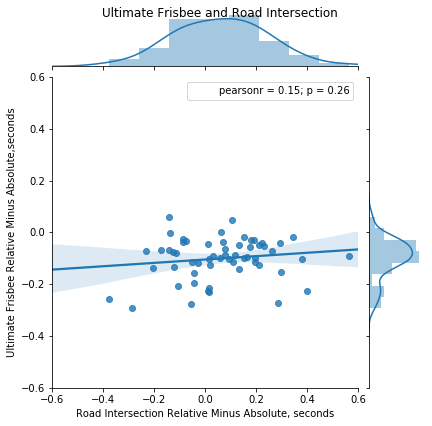

In [5]:
nav_and_friz = sns.jointplot(pivoted['Nav_Rel_minus_Abs'], pivoted['Frisbee_Rel_minus_Abs'], kind="reg",size = 6)
nav_and_friz.set_axis_labels('Road Intersection Relative Minus Absolute, seconds', 
                             'Ultimate Frisbee Relative Minus Absolute,seconds')
plt.xlim(-.6,.6)
plt.ylim(-.6,.6)
nav_and_friz.fig.suptitle('Ultimate Frisbee and Road Intersection')



The correlation between relative / absolute reference frame preference for road intersection and ultimate frisbee with SBSOD and frisbee playing experience

Average ultimate frisbee playing in years: 7.78
Standard deviation ultimate frisbee playing in years: 5.03


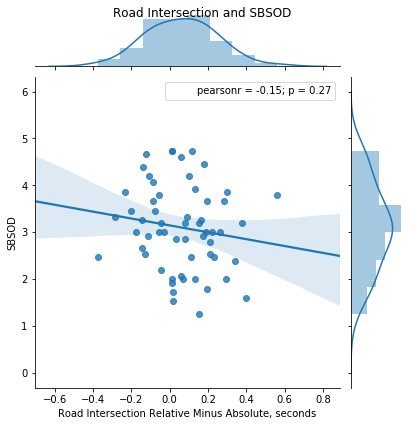

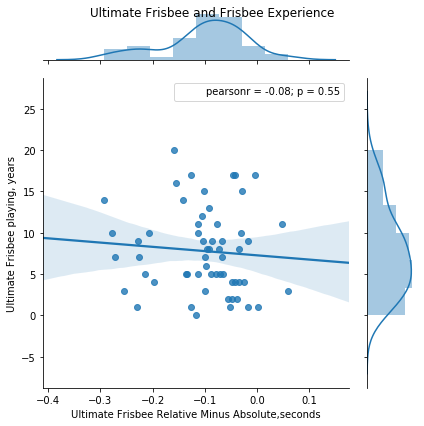

In [6]:
print('Average ultimate frisbee playing in years: {:.2f}\nStandard deviation ultimate frisbee playing in years: {:.2f}'
      .format(merged.Friz_Total_Years_Played.mean(), merged.Friz_Total_Years_Played.std()))


nav_pref_SBSOD = sns.jointplot(merged[('Nav_Rel_minus_Abs','','')], merged['SBSOD_AVERAGE'], kind="reg", size =6)
nav_pref_SBSOD.set_axis_labels('Road Intersection Relative Minus Absolute, seconds', 'SBSOD')
nav_pref_SBSOD.fig.suptitle('Road Intersection and SBSOD')

friz_pref_exp = sns.jointplot(merged[('Frisbee_Rel_minus_Abs','','')], merged['Friz_Total_Years_Played'], kind="reg", size =6)
friz_pref_exp.set_axis_labels('Ultimate Frisbee Relative Minus Absolute,seconds','Ultimate Frisbee playing, years')
friz_pref_exp.fig.suptitle('Ultimate Frisbee and Frisbee Experience')

plt.tight_layout()
plt.show()

# Exploratory Analyses
## Accuracy

Accuracy for condition overall
condition
Frisbee       0.974946
Navigation    0.902478
Name: Trials_responsecorr, dtype: float64
condition
Frisbee       0.034125
Navigation    0.095708
Name: Trials_responsecorr, dtype: float64


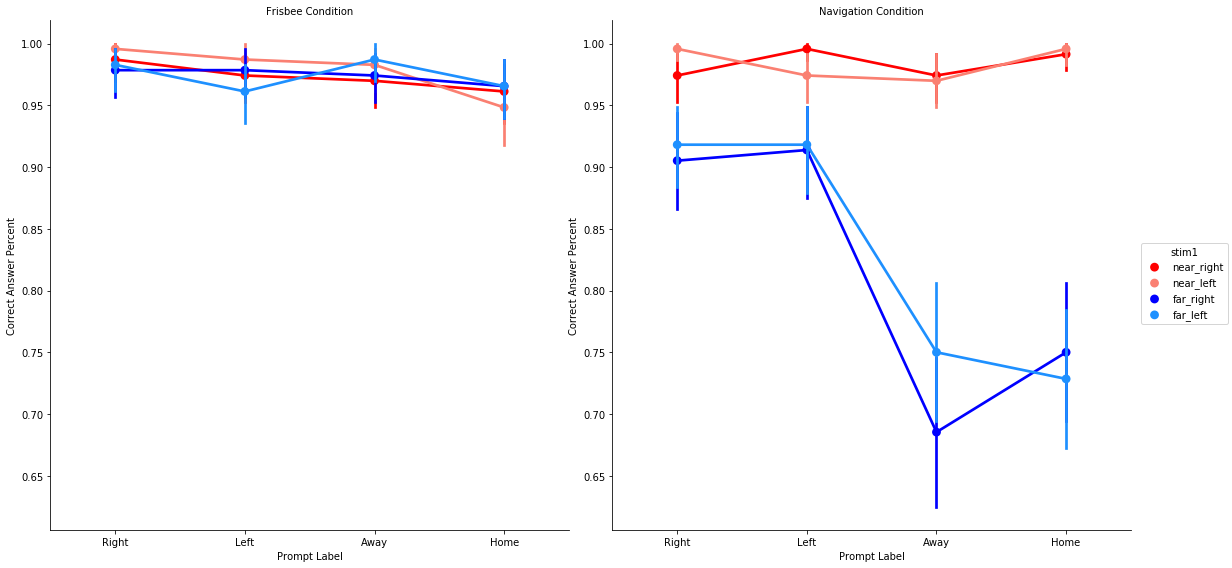

In [7]:
print('Accuracy for condition overall')
print(df.groupby(['condition'])['Trials_responsecorr'].mean())
print(df.groupby(['condition', 'participant']).mean()
            .groupby('condition')['Trials_responsecorr'].std())


# Pivot table of correct trials, sorted by Far-Absolute navigation trials. 
# Commented out for brevity.
# display(pivotedCorrectAns.sort_values([('Navigation','Far','Absolute')]))

# Note: Forehand is coded as "left" and Backhand is coded as "Right"
correct_ans = sns.factorplot(x = "prompt1", y = "Trials_responsecorr", data = df, hue = "stim1", palette=['red','salmon','blue','dodgerblue'],
                    kind = "point", size = 8,col='condition', order=['Right','Left','Away','Home'], hue_order=['near_right','near_left','far_right','far_left'])
correct_ans.set(xlabel='Prompt Label', ylabel='Correct Answer Percent')
correct_ans.set_titles("{col_name} Condition")

plt.show()



### See R-script for 2x2x2 ANOVA

## All pairwise ttests for accuracy

In [8]:

pivotedCorr = df.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsecorr',aggfunc=np.mean)


print('Bonferroni corrected error rate = {:.3f}\n'.format(.05/28))
for i in range(0,8):
    for j in range(1,8):
        if i < j:
            ttestAndMeansSDswithin(pivotedCorr.iloc[:,i],pivotedCorr.iloc[:,j],pivotedCorr.iloc[:,i].name,pivotedCorr.iloc[:,j].name)



Bonferroni corrected error rate = 0.002

('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Frisbee', 'Far', 'Relative') M = 0.98, SD = 0.06
 t(57) = 0.25, p = 0.80, d = 0.03
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Frisbee', 'Near', 'Absolute') M = 0.97, SD = 0.05
 t(57) = 0.78, p = 0.44, d = 0.10
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Frisbee', 'Near', 'Relative') M = 0.99, SD = 0.03
 t(57) = 1.57, p = 0.12, d = 0.22
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Navigation', 'Far', 'Absolute') M = 0.73, SD = 0.37
 t(57) = 4.94, p = 0.0000, d = 0.86
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Navigation', 'Far', 'Relative') M = 0.91, SD = 0.09
 t(57) = 4.03, p = 0.0002, d = 0.60
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Navigation', 'Near', 'Absolute') M = 0.98, SD = 0.03
 t(57) = 1.05, p = 0.30, d = 0.16
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Navigation', 'Near', 'Relative') M = 0.98, SD = 0.03
 t(57) 

### Flippers and non-flippers.

In [9]:
flippersCorrNoNFA = flippersCorr.drop([('Navigation','Far','Absolute')],axis=1)
nonflippersCorrNoNFA = nonflippersCorr.drop([('Navigation','Far','Absolute')],axis=1)


justNavMeanFlippers = flippersCorrNoNFA.drop([('Frisbee')],axis=1).mean(axis=1)
justNavMeanNonFlippers = nonflippersCorrNoNFA.drop([('Frisbee')],axis=1).mean(axis=1)

justFrizMeanFlippers = flippersCorrNoNFA.drop([('Navigation')],axis=1).mean(axis=1)
justFrizMeanNonFlippers = nonflippersCorrNoNFA.drop([('Navigation')],axis=1).mean(axis=1)

# Flipper and non-flipper accuracy on non-Far-Absolute road intersection trials
ttestAndMeansSDs(justNavMeanFlippers,justNavMeanNonFlippers,'Nav Flippers', 'Nav Non-Flippers')
# Flipper and non-flipper accuracy on all ultimate frisbee trials
ttestAndMeansSDs(justFrizMeanFlippers,justFrizMeanNonFlippers, 'Friz Flippers','Friz Non-flippers')


Nav Flippers M = 15.47, SD = 0.54;  Nav Non-Flippers M = 15.33, SD = 0.63
 t(56) = 0.83, p = 0.41, d = 0.25
Friz Flippers M = 15.47, SD = 0.79;  Friz Non-flippers M = 15.65, SD = 0.40
 t(56) = 1.16, p = 0.25, d = 0.29


In [10]:
# flippers and non-flippers differ on on relative (not absolute) reaction times! 
for i in flippersRT:
    ttestAndMeansSDs(flippersRT[i],nonflippersRT[i],'flippers {}'.format(i),'nonflippers {}'.format(i))

flippers ('Frisbee', 'Far', 'Absolute') M = 1.45, SD = 0.87;  nonflippers ('Frisbee', 'Far', 'Absolute') M = 1.27, SD = 0.39
 t(56) = 1.11, p = 0.27, d = 0.27
flippers ('Frisbee', 'Far', 'Relative') M = 1.30, SD = 0.81;  nonflippers ('Frisbee', 'Far', 'Relative') M = 1.16, SD = 0.34
 t(56) = 0.97, p = 0.33, d = 0.24
flippers ('Frisbee', 'Near', 'Absolute') M = 1.33, SD = 0.51;  nonflippers ('Frisbee', 'Near', 'Absolute') M = 1.20, SD = 0.36
 t(56) = 1.07, p = 0.29, d = 0.29
flippers ('Frisbee', 'Near', 'Relative') M = 1.24, SD = 0.72;  nonflippers ('Frisbee', 'Near', 'Relative') M = 1.10, SD = 0.37
 t(56) = 1.00, p = 0.32, d = 0.25
flippers ('Navigation', 'Far', 'Absolute') M = 1.58, SD = 0.55;  nonflippers ('Navigation', 'Far', 'Absolute') M = 1.09, SD = 0.45
 t(56) = 3.53, p = 0.0008, d = 0.98
flippers ('Navigation', 'Far', 'Relative') M = 1.34, SD = 0.33;  nonflippers ('Navigation', 'Far', 'Relative') M = 1.38, SD = 0.52
 t(56) = 0.30, p = 0.76, d = 0.09
flippers ('Navigation', 'Nea

In [11]:

display(flippersOtherData.groupby(['Friz_Force_Preference'])['Friz_Position'].count())
display(nonflippersOtherData.groupby(['Friz_Force_Preference'])['Friz_Position'].count())

display(flippersOtherData.groupby('Sex')['Sex'].count())
display(nonflippersOtherData.groupby('Sex')['Sex'].count())




Friz_Force_Preference
Forehand / Backhand     2
Home / Away            13
Name: Friz_Position, dtype: int64

Friz_Force_Preference
Forehand / Backhand    17
Home / Away            19
Name: Friz_Position, dtype: int64

Sex
female     3
male      14
Name: Sex, dtype: int64

Sex
female    15
male      26
Name: Sex, dtype: int64

## Reaction Time

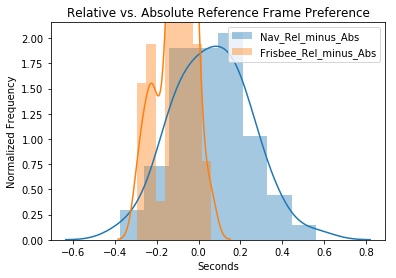

Frisbee M = -0.10, SD = 0.08;  Navigation M = 0.06, SD = 0.18
 t(57) = 6.61, p = 0.0000, d = 0.96


Ttest_1sampResult(statistic=-9.7083892647272254, pvalue=1.0998657863313898e-13)

Ttest_1sampResult(statistic=2.5949826243020597, pvalue=0.012006637763209729)

LeveneResult(statistic=30.373944843455881, pvalue=2.2421407429114304e-07)

In [12]:
# Ultimate frisbee versus road intersection task overall reaction time differences.

doubleDistPlot('Frisbee_Rel_minus_Abs','Nav_Rel_minus_Abs',pivoted,abs_and_rel=False,title='Relative vs. Absolute Reference Frame Preference')

# Ultimate frisbee versus road intersection t-test
ttestAndMeansSDswithin(pivoted['Frisbee_Rel_minus_Abs'],pivoted['Nav_Rel_minus_Abs'],'Frisbee', 'Navigation')

# One Sample t-tests
display(scipy.stats.ttest_1samp(pivoted['Frisbee_Rel_minus_Abs'],0))
display(scipy.stats.ttest_1samp(pivoted['Nav_Rel_minus_Abs'],0))

# Significantly different variances
scipy.stats.levene(pivoted['Frisbee_Rel_minus_Abs'],pivoted['Nav_Rel_minus_Abs'])

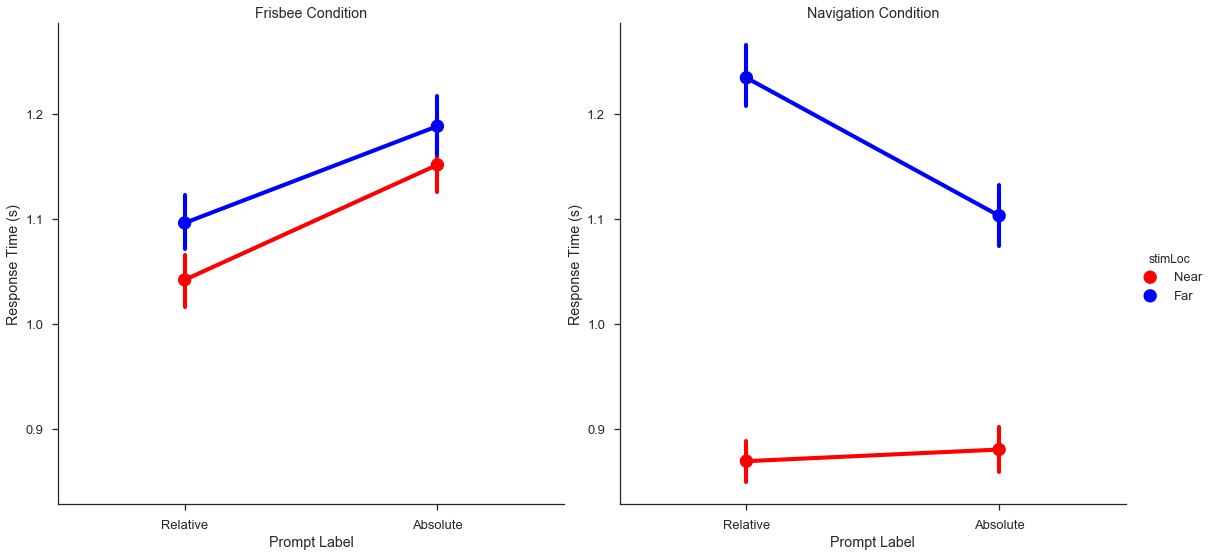

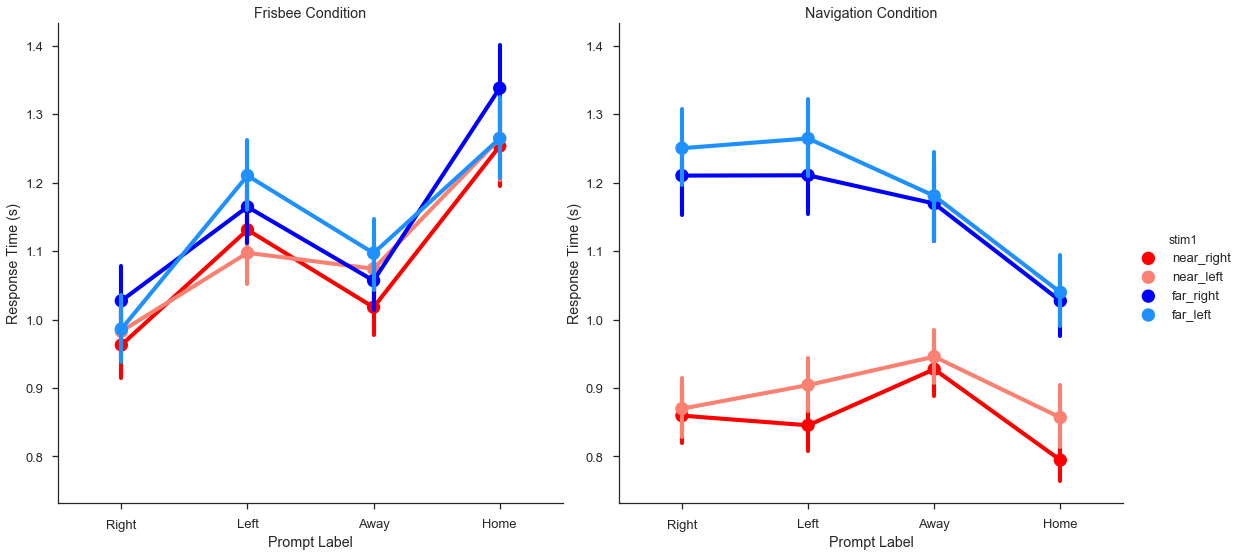

In [13]:
# Reaction time by trial type within ultimate frisbee and road intersection tasks
sns.set_style('ticks')
sns.set_context('talk')
ax1 = sns.factorplot(x = "promptType", y = "Trials_responsert", data = dataForPlot, hue = "stimLoc",palette=['red','blue'], 
                     kind = "point", size = 8,col='condition')
ax1.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax1.set_titles("{col_name} Condition")

ax2 = sns.factorplot(x = "prompt1", y = "Trials_responsert", data = dataForPlot, hue = "stim1", palette=['red','salmon','blue','dodgerblue'],
                    kind = "point", size = 8,col='condition', order=['Right','Left','Away','Home'], hue_order=['near_right','near_left','far_right','far_left'])

ax2.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax2.set_titles("{col_name} Condition")

plt.show()

### See R-script for repeated-measures ANOVA

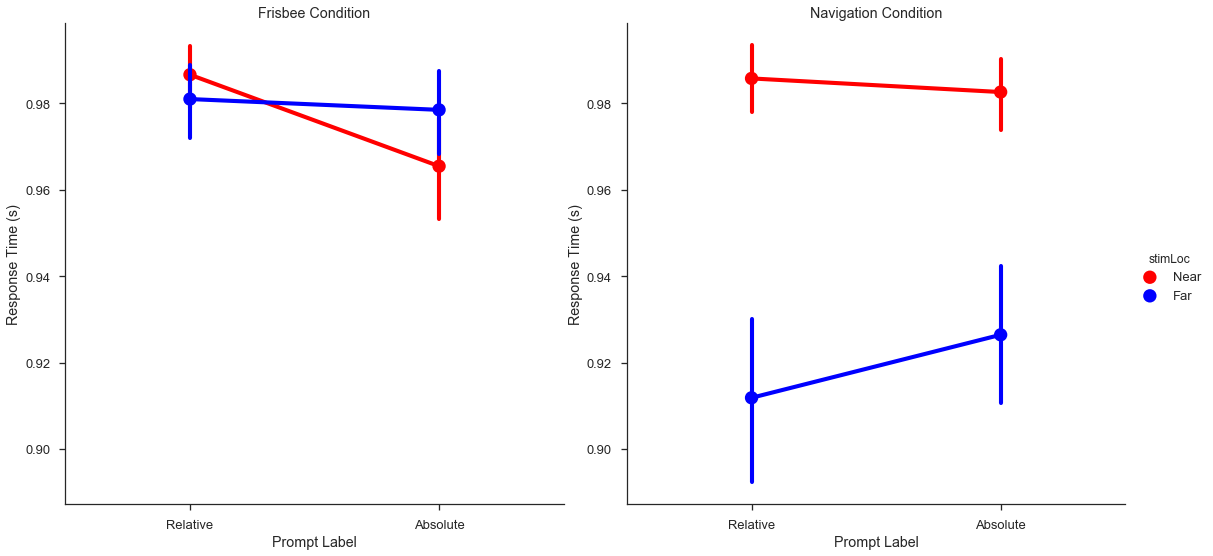

In [14]:
sns.set_style('ticks')
sns.set_context('talk')
ax1 = sns.factorplot(x = "promptType", y = "newCorrect", data = dataForPlot,hue="stimLoc",palette=['red','blue'], 
                     kind = "point", size = 8,col='condition')
ax1.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax1.set_titles("{col_name} Condition")
